In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from data_prep import backward_elim, splitting, slicing

from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, GRU
from tensorflow.keras import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
pre_label = pd.read_csv('Data/dengue_labels_train_raw.csv')
pre_sj = pd.read_csv('Data/sj_features_imputed_20200519.csv', index_col = 'week_start_date', parse_dates=['week_start_date'])
pre_iq = pd.read_csv('Data/iq_features_imputed_20200520.csv', index_col = 'week_start_date', parse_dates=['week_start_date'])

iq_pop = pd.read_csv('Data/iq_pop.csv')

In [3]:
pre_sj.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,
1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
sj_label = pre_label[pre_label['city'] == 'sj']['total_cases']
iq_label = pre_label[pre_label['city'] == 'iq']['total_cases']

sj_size = sj_label.shape[0]
iq_size = iq_label.shape[0]


# Replace normalized total cases with the original one
# since LSTM and other ANNs do not require normality assumption
sj = pre_sj.iloc[:sj_size]
sj['total_cases'] = sj_label.values

iq = pre_iq.iloc[:iq_size]
iq['total_cases'] = iq_label.values

/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Scaling

In [6]:
sj_scaler = MinMaxScaler()
sj_scaled = sj_scaler.fit_transform(sj)

iq_scaler = MinMaxScaler()
iq_scaled = iq_scaler.fit_transform(iq)

In [7]:
sj_scaled.shape

(936, 21)

# Generate Input for LSTM

In [8]:
lag_in = 1
lag_out = 1

sj_input = series_to_supervised(sj_scaled, lag_in, lag_out)
iq_input = series_to_supervised(iq_scaled, lag_in, lag_out)

#sj_input['past_cases'] = sj_label.iloc[:-1]
#sj_input['total_cases'] = sj_label.iloc[1:]

In [9]:
sj_input.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t)
1,0.587840,0.626763,0.523701,0.541889,0.031797,0.261008,0.269185,0.339933,0.307692,0.452055,...,0.510214,0.058423,0.473460,0.330233,0.535573,0.342175,0.561798,0.564103,0.028114,0.010846
2,0.640416,0.669811,0.435300,0.492142,0.058423,0.362993,0.384888,0.528474,0.476923,0.520548,...,0.734988,0.088428,0.664509,0.306977,0.535573,0.363395,0.617978,0.641026,0.135338,0.008677
3,0.487412,0.704284,0.422680,0.526662,0.088428,0.454027,0.456907,0.710356,0.415385,0.643836,...,0.652660,0.039324,0.641761,0.348837,0.640316,0.416446,0.741573,0.705128,0.013076,0.006508
4,0.594546,0.785005,0.594845,0.672866,0.039324,0.486881,0.514758,0.695111,0.553846,0.602740,...,0.658555,0.019252,0.711300,0.539535,0.843874,0.899204,0.932584,0.782051,0.018960,0.013015
5,0.669649,0.804187,0.652699,0.698613,0.019252,0.571755,0.586777,0.757841,0.630769,0.671233,...,0.631272,0.024526,0.711670,0.241860,0.729249,0.448276,0.865169,0.782051,0.127820,0.004338


In [11]:
sj_input.head()

# the total_cases, our target variable, is labeled var21

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t)
1,0.587840,0.626763,0.523701,0.541889,0.031797,0.261008,0.269185,0.339933,0.307692,0.452055,...,0.510214,0.058423,0.473460,0.330233,0.535573,0.342175,0.561798,0.564103,0.028114,0.010846
2,0.640416,0.669811,0.435300,0.492142,0.058423,0.362993,0.384888,0.528474,0.476923,0.520548,...,0.734988,0.088428,0.664509,0.306977,0.535573,0.363395,0.617978,0.641026,0.135338,0.008677
3,0.487412,0.704284,0.422680,0.526662,0.088428,0.454027,0.456907,0.710356,0.415385,0.643836,...,0.652660,0.039324,0.641761,0.348837,0.640316,0.416446,0.741573,0.705128,0.013076,0.006508
4,0.594546,0.785005,0.594845,0.672866,0.039324,0.486881,0.514758,0.695111,0.553846,0.602740,...,0.658555,0.019252,0.711300,0.539535,0.843874,0.899204,0.932584,0.782051,0.018960,0.013015
5,0.669649,0.804187,0.652699,0.698613,0.019252,0.571755,0.586777,0.757841,0.630769,0.671233,...,0.631272,0.024526,0.711670,0.241860,0.729249,0.448276,0.865169,0.782051,0.127820,0.004338


In [12]:
sj_input.shape

(935, 42)

In [20]:
# Drop unused columns
sj_input.drop(sj_input.columns[range(21, 41)], axis = 1, inplace = True)
iq_input.drop(iq_input.columns[range(21, 41)], axis = 1, inplace = True)

In [21]:
# Split the data
sj_train_no = int(sj_input.shape[0] * 0.7)
iq_train_no = int(iq_input.shape[0] * 0.7)

sj_train, sj_test = sj_input.values[:sj_train_no, :], sj_input.values[sj_train_no:, :]
iq_train, iq_test = iq_input.values[:iq_train_no, :], iq_input.values[iq_train_no:, :]

sj_x_train, sj_y_train = sj_train[:, :-1], sj_train[:, -1]
sj_x_test, sj_y_test = sj_test[:, :-1], sj_test[:, -1]
iq_x_train, iq_y_train = iq_train[:, :-1], iq_train[:, -1]
iq_x_test, iq_y_test = iq_test[:, :-1], iq_test[:, -1]

In [22]:
# Reshape training data
def lstm_reshape(array):
    return array.reshape((array.shape[0], 1, array.shape[1]))

sj_x_train = lstm_reshape(sj_x_train)
sj_x_test = lstm_reshape(sj_x_test)
iq_x_train = lstm_reshape(iq_x_train)
iq_x_test = lstm_reshape(iq_x_test)

# LSTM - San Juan 

In [57]:
# Define a model
sj_model = Sequential()
sj_model.add(GRU(50, input_shape=(sj_x_train.shape[1], sj_x_train.shape[2])))
sj_model.add(Dense(1))

# model from DrivenData
"""sj_model = Sequential()
sj_model.add(Bidirectional(LSTM(130, activation='relu'), input_shape=(sj_x_train.shape[1], sj_x_train.shape[2])))
sj_model.add(Dropout(0.1))
sj_model.add(Dense(1))"""

sj_model.compile(loss='mae', optimizer='adam')

fitted = sj_model.fit(sj_x_train, sj_y_train, epochs = 55, batch_size=72, validation_data=(sj_x_test, sj_y_test), 
                   verbose = 0, shuffle = False)

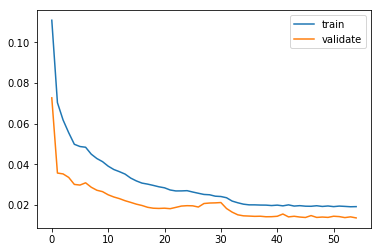

In [58]:
plt.plot(fitted.history['loss'], label = 'train')
plt.plot(fitted.history['val_loss'], label = 'validate')
plt.legend(loc = 'best')
plt.show()

In [71]:
sj_pred = sj_model.predict(sj_x_test)

In [72]:
# Rescale prediction
sj_x_test_r = sj_x_test.reshape(sj_x_test.shape[0], sj_x_test.shape[2])
for_rescaled = np.concatenate((sj_x_test_r[:, :-1], sj_pred), axis = 1)
sj_rescaled = sj_scaler.inverse_transform(for_rescaled)
sj_real_pred = [int(x) for x in sj_rescaled[:, -1]]

# Rescale y_test
sj_y_test = sj_y_test.reshape((len(sj_y_test), 1))
for_rescaled = np.concatenate((sj_x_test_r[:, :-1], sj_y_test), axis = 1)
sj_rescaled = sj_scaler.inverse_transform(for_rescaled)
sj_real_y_test = [int(x) for x in sj_rescaled[:, -1]]

In [73]:
mean_absolute_error(sj_real_y_test, sj_real_pred)

6.313167259786477

# LSTM - Iquitos

In [64]:
# Define a model
iq_model = Sequential()
iq_model.add(GRU(20, input_shape=(iq_x_train.shape[1], iq_x_train.shape[2])))
iq_model.add(Dense(1))
iq_model.compile(loss='mae', optimizer='adam')

fitted = iq_model.fit(iq_x_train, iq_y_train, epochs = 80, batch_size=72, validation_data=(sj_x_test, sj_y_test), 
                   verbose = 0, shuffle = False)

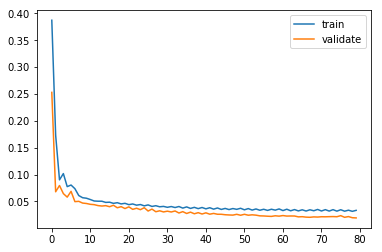

In [65]:
plt.plot(fitted.history['loss'], label = 'train')
plt.plot(fitted.history['val_loss'], label = 'validate')
plt.legend(loc = 'best')
plt.show()

In [68]:
iq_pred = iq_model.predict(iq_x_test)

In [69]:
# Rescale prediction
iq_x_test_r = iq_x_test.reshape(iq_x_test.shape[0], iq_x_test.shape[2])
for_rescaled = np.concatenate((iq_x_test_r[:, :-1], iq_pred), axis = 1)
iq_rescaled = iq_scaler.inverse_transform(for_rescaled)
iq_real_pred = [int(x) for x in iq_rescaled[:, -1]]

# Rescale y_test
iq_y_test = iq_y_test.reshape((len(iq_y_test), 1))
for_rescaled = np.concatenate((iq_x_test_r[:, :-1], iq_y_test), axis = 1)
iq_rescaled = iq_scaler.inverse_transform(for_rescaled)
iq_real_y_test = [int(x) for x in iq_rescaled[:, -1]]

In [70]:
mean_absolute_error(iq_real_y_test, iq_real_pred)

5.096153846153846

# Real Forecasting 

In [33]:
sj_valid = pre_sj.iloc[sj_size:]
iq_valid = pre_iq.iloc[iq_size:]

sj_valid['total_cases'] = 0
iq_valid['total_cases'] = 0


sj_valid_scaled = sj_scaler.transform(sj_valid)
iq_valid_scaled = iq_scaler.transform(iq_valid)

sj_valid.drop('total_cases', axis = 1, inplace = True)
iq_valid.drop('total_cases', axis = 1, inplace = True)

/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/pasin/opt/anaconda3/envs/env01/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://